In [1]:
from IPython.display import Latex

In [2]:
import ast

In [3]:
import showast

### Goal

In this project, we will try to build a transpiler from Python syntax into Latex. This would support converting simple expression such as (`x**2 + 1` -> $x^2 +1$). The expression would be valid Python expression. We would parse the the Python expression into an AST. From this AST, we would convert the operator from the Python version into Latex (such as `**` -> ^). Then we would also display the Latex expression in Jupyter for demonstration purposes. 

This notebook needs to be run on **Python 3.6** minimum due to the use of f-strings.

Some examples:


| `python` | $\LaTeX$ |
|:--------:|:-------:|
| `x**2` | $x^2$ |
| `x**2 + x - 1` | $x^2 + x - 1$ |
| `3*x + x - 1` | $3 \cdot x + x -1$ |
| `1/x` | $\frac{1}{x}$|
| `x**2 / (x**2 + x - 1)` | $\frac{x^2}{x^2 + x - 1}$|
|`x == 1` | $x = 1$|
| ` x< 1` | $x < 1$|
|`sum(x)`|$\sum { x } $|
|`sum(3*x)`|$\sum { 3 \cdot x}  $|


# Code

In [4]:
# operator = Add | Sub | Mult | Div | Mod | Pow 
# cmpop = Eq | NotEq | Lt | LtE | Gt | GtE | Is | IsNot | In | NotIn
# expr = BinOp(expr left, operator op, expr right)
#          | Compare(expr left, cmpop* ops, expr* comparators)
#          | Num(object n) -- a number as a PyObject.
#          | Name(identifier id, expr_context ctx)
#         | Call(expr func, expr* args, keyword* keywords)


#### BNF

$$
\begin{eqnarray*}
\textit{CompareOperator} & ::= &  \texttt{==} \\ 
& | & \texttt{!=} \\ 
& | & \texttt{<} \\  
& | & \texttt{<=} \\ 
& | & \texttt{>} \\  
& | & \texttt{>=} \\
\textit{BinaryOperator} & ::= & \texttt{+}  \\
& | & \texttt{-}  \\
& | & \texttt{*}  \\
& | & \texttt{/}  \\
& | & \texttt{**}  \\
\textit{Expression} & ::= & < \textit{Expression} > < \textit{BinaryOperator}> < \textit{Expression} > \\
& | & < \textit{Expression} > <\textit{CompareOperator}> <\textit{Expression}> \\
& | & < \textit{Number} > \\
& | & < \textit{Name} > \\
& | & < Call > 
\textit{Number} & ::= & \texttt{int}\\
& | & \texttt{float}\\
\textit{Name} & ::= & \texttt{str}\\
\textit{Call} & ::= & < \textit{FuncName} > \texttt{(} < \textit{Expression} > \texttt{)} \\ 
\textit{FuncName} & ::= & \texttt{sum} \\
\end{eqnarray*}
$$

In [5]:
OP_MAP = {
    ast.Add : "+",
    ast.Sub: "-",
    ast.Mult: "\\cdot", # This is due to preference
    ast.Pow : "^",
    ast.Div: None, # Special case implemented below
    ast.Eq: "=",
    ast.NotEq: "\\neq",
    ast.Lt: "<",
    ast.Gt: ">",
    ast.LtE: "\\leq" ,
    ast.GtE: "\\geq",

}

#### Syntax check

In [6]:
class Latexifiable(ast.NodeVisitor):
    OP_MAP = OP_MAP
    
    def visit_Module(self, node):
        return all(map(self.visit, node.body))
    
    def visit_Expr(self, node):
        return self.visit(node.value)  
    
    def visit_Name(self, node):

        return True
    
    def visit_Num(self, node):
        return True
    
    def visit_BinOp(self, node):
        l = self.visit(node.left)
        r = self.visit(node.right)
        op = type(node.op)
        return all(
            [op in set(self.OP_MAP.keys()),
            l,r]
        )
        
    def visit_Compare(self, node):
        l = self.visit(node.left)
        r = self.visit(node.comparators[0])
        op = type(node.ops[0])
        return all(
            [op in set(self.OP_MAP.keys()),
            l,r]
        )
    def visit_Call(self, node):
        args = self.visit(node.args[0])
        func = self.visit(node.func)
        if func == "sum":
            return True
        return False

#### Transpiler

In [7]:
class Latexify(ast.NodeVisitor):
    OP_MAP = OP_MAP
    
    def visit_Module(self, node):
        return list(map(self.visit, node.body))
    
    def visit_Expr(self, node):
        return self.visit(node.value)  
    
    def visit_Name(self, node):

        return str(node.id)
    
    def visit_Num(self, node):
        return node.n
    
    def visit_BinOp(self, node):
        l = self.visit(node.left)
        r = self.visit(node.right)
        op = self.OP_MAP.get(type(node.op))
        
        if type(node.op) is ast.Div:
            return f"\\frac{{{l}}}{{{r}}}"
                
        if not op:
            raise ValueError("Can't find supported operator")

        return f"{{ {l} }} {op} {{ {r} }}" # Who knows that escaping braces in Python f-string is more braces
    
    def visit_Compare(self, node):
        l = self.visit(node.left)
        r = self.visit(node.comparators[0])
        op = self.OP_MAP.get(type(node.ops[0]))

        if not op:
            raise ValueError("Can't find supported operator")
            
        return f"{{ {l} }} {op} {{ {r} }}"

    def visit_Call(self, node):
        args = self.visit(node.args[0])
        func = self.visit(node.func)
        if func == "sum":
            # Make the sum sign
            return f" \sum {{ {args} }} "

In [8]:
def show_parsed(v):
    """
    Display the converted LaTeX formula in Jupyter
    
    :param v: The Python expression to convert into Latex
    """
    p = ast.parse(v)
    r = Latexify().visit(p)
    lfb = Latexifiable().visit(p)
    print(f"Is Latexifiable?: {lfb}")
    print(f"Latex: {r[0]}")
    if len(r) > 0:
        return Latex(f"${r[0]}$")

#### Tests

In [9]:
show_parsed("x")

Is Latexifiable?: True
Latex: x


<IPython.core.display.Latex object>

In [10]:
show_parsed("x+1")

Is Latexifiable?: True
Latex: { x } + { 1 }


<IPython.core.display.Latex object>

In [11]:
show_parsed("x**2")

Is Latexifiable?: True
Latex: { x } ^ { 2 }


<IPython.core.display.Latex object>

In [12]:
show_parsed("x**2 + x +1")

Is Latexifiable?: True
Latex: { { { x } ^ { 2 } } + { x } } + { 1 }


<IPython.core.display.Latex object>

In [13]:
show_parsed("3*x  + x - 1")

Is Latexifiable?: True
Latex: { { { 3 } \cdot { x } } + { x } } - { 1 }


<IPython.core.display.Latex object>

In [14]:
show_parsed("1/x")

Is Latexifiable?: True
Latex: \frac{1}{x}


<IPython.core.display.Latex object>

In [15]:
show_parsed("x**2 / (x**2 + x - 1)")

Is Latexifiable?: True
Latex: \frac{{ x } ^ { 2 }}{{ { { x } ^ { 2 } } + { x } } - { 1 }}


<IPython.core.display.Latex object>

In [16]:
show_parsed("x == 1")

Is Latexifiable?: True
Latex: { x } = { 1 }


<IPython.core.display.Latex object>

In [17]:
show_parsed("x + 2 < 3")

Is Latexifiable?: True
Latex: { { x } + { 2 } } < { 3 }


<IPython.core.display.Latex object>

In [18]:
show_parsed("x + 2 >= 3")

Is Latexifiable?: True
Latex: { { x } + { 2 } } \geq { 3 }


<IPython.core.display.Latex object>

In [19]:
show_parsed("sum(x)")

Is Latexifiable?: False
Latex:  \sum { x } 


<IPython.core.display.Latex object>

In [20]:
show_parsed("sum(3*x)")

Is Latexifiable?: False
Latex:  \sum { { 3 } \cdot { x } } 


<IPython.core.display.Latex object>

# Scratch work

A library called `showast` can be install to draw the AST of any Python expression. 

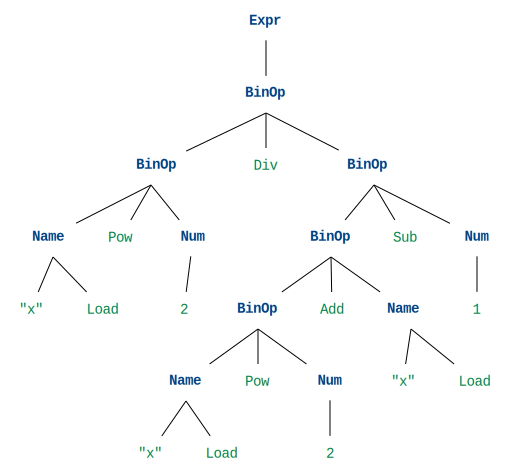

In [21]:
%%showast

x**2 / (x**2 + x - 1)

In [23]:
ast.dump(ast.parse("sum(x**2 for x in y)"))

"Module(body=[Expr(value=Call(func=Name(id='sum', ctx=Load()), args=[GeneratorExp(elt=BinOp(left=Name(id='x', ctx=Load()), op=Pow(), right=Num(n=2)), generators=[comprehension(target=Name(id='x', ctx=Store()), iter=Name(id='y', ctx=Load()), ifs=[], is_async=0)])], keywords=[]))])"

In [24]:
ast.dump(ast.parse("x**2 / (x**2 + x - 1)"))

"Module(body=[Expr(value=BinOp(left=BinOp(left=Name(id='x', ctx=Load()), op=Pow(), right=Num(n=2)), op=Div(), right=BinOp(left=BinOp(left=BinOp(left=Name(id='x', ctx=Load()), op=Pow(), right=Num(n=2)), op=Add(), right=Name(id='x', ctx=Load())), op=Sub(), right=Num(n=1))))])"

In [25]:
ast.dump(ast.parse("x==1"))

"Module(body=[Expr(value=Compare(left=Name(id='x', ctx=Load()), ops=[Eq()], comparators=[Num(n=1)]))])"

In [26]:
ast.dump(ast.parse("sum(x)"))

"Module(body=[Expr(value=Call(func=Name(id='sum', ctx=Load()), args=[Name(id='x', ctx=Load())], keywords=[]))])"